# ARIMA Model

We'll take a look at the ARIMA model which attempts to predict the value of 1 variable based off of the past.

## Installing and importing required libraries

In [269]:
import numpy as np
import pandas as pd
import pickle 
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_squared_error

Load the data

In [270]:
with open('../data/raw_data.pickle', 'rb') as f:
    data = pickle.load(f)

In [271]:
with open('../data/train_data.pickle', 'rb') as f:
    train_data = pickle.load(f)

Take a look at the data

In [272]:
data

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


Only interested in the pollution as the ARIMA model only takes one variable. Want to visualise what the pollution data looks like

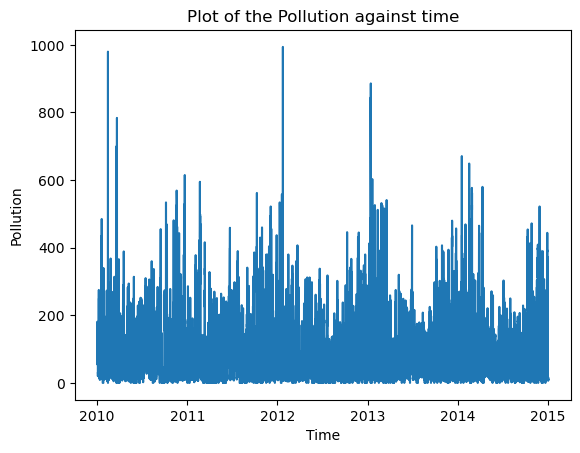

In [273]:
variable_of_interest = data['pollution']


plt.plot(variable_of_interest)
plt.title('Plot of the Pollution against time')
plt.xlabel('Time')
plt.ylabel('Pollution')
plt.show()

Taking a look at the correlation graphs for the pollution variable so we can decide how many lags we need to include

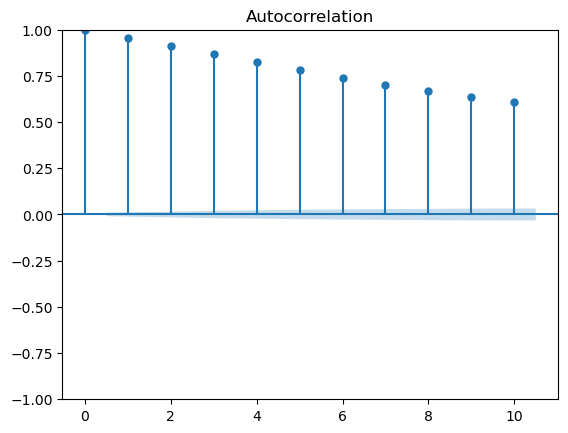

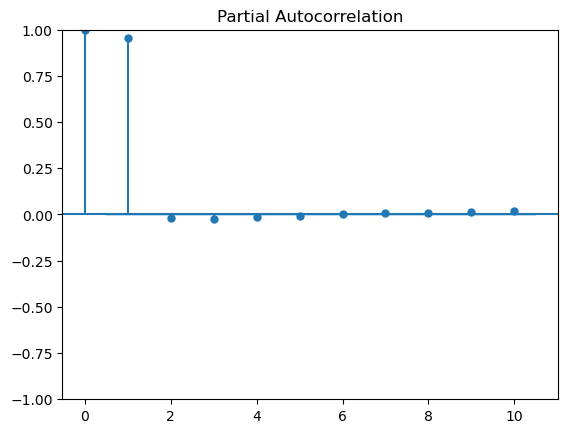

In [274]:
plot_acf(data['pollution'].dropna(), lags=10)
plt.show()

plot_pacf(data['pollution'].dropna(), lags=10)
plt.show()

Seems only the previous value has any real impact so we can take p = 1

Create training and test splits

In [275]:
train_size = int(len(train_df) * 0.999)
train_df1 = train_df[:train_size]
val_df = train_df[train_size:]
train_df2 = train_df1[['pollution']]


In [276]:
train_df2

,pollution
date,
2010-01-02 00:00:00,0.129779
2010-01-02 01:00:00,0.148893
2010-01-02 02:00:00,0.159960
2010-01-02 03:00:00,0.182093
2010-01-02 04:00:00,0.138833
...,...
2014-06-30 15:00:00,0.074447
2014-06-30 16:00:00,0.072435
2014-06-30 17:00:00,0.051308


In [277]:
model = ARIMA(train_df2, order=(1, 0, 2))
arima_model = model.fit()

c:\Users\djjjo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\djjjo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\djjjo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              pollution   No. Observations:                39380
Model:                 ARIMA(1, 0, 2)   Log Likelihood               85003.633
Date:                Thu, 21 Nov 2024   AIC                        -169997.267
Time:                        01:06:41   BIC                        -169954.362
Sample:                    01-02-2010   HQIC                       -169983.676
                         - 06-30-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0951      0.004     23.559      0.000       0.087       0.103
ar.L1          0.9508      0.001    819.998      0.000       0.949       0.953
ma.L1          0.0137      0.001     10.777      0.0

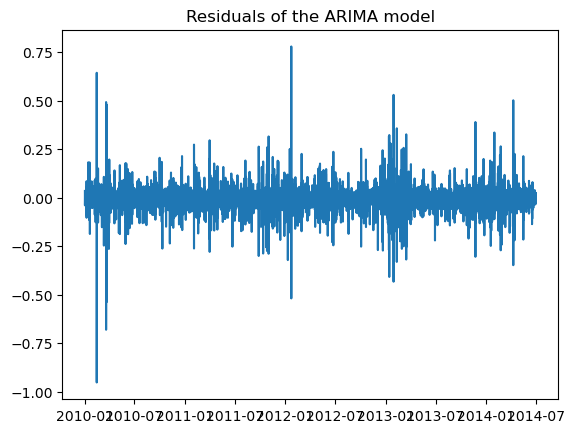

In [ ]:
print(arima_model.summary())
residuals = arima_model.resid
plt.plot(residuals)
plt.title("Residuals of the ARIMA model")
plt.show()

In [279]:
forecast = arima_model.forecast(steps=len(val_df))
forecast

2014-06-30 20:00:00    0.042752
2014-06-30 21:00:00    0.044977
2014-06-30 22:00:00    0.047442
2014-06-30 23:00:00    0.049786
2014-07-01 00:00:00    0.052015
2014-07-01 01:00:00    0.054133
2014-07-01 02:00:00    0.056148
2014-07-01 03:00:00    0.058063
2014-07-01 04:00:00    0.059884
2014-07-01 05:00:00    0.061615
2014-07-01 06:00:00    0.063261
2014-07-01 07:00:00    0.064826
2014-07-01 08:00:00    0.066314
2014-07-01 09:00:00    0.067729
2014-07-01 10:00:00    0.069074
2014-07-01 11:00:00    0.070353
2014-07-01 12:00:00    0.071569
2014-07-01 13:00:00    0.072725
2014-07-01 14:00:00    0.073824
2014-07-01 15:00:00    0.074869
2014-07-01 16:00:00    0.075863
2014-07-01 17:00:00    0.076808
2014-07-01 18:00:00    0.077706
2014-07-01 19:00:00    0.078560
2014-07-01 20:00:00    0.079372
2014-07-01 21:00:00    0.080144
2014-07-01 22:00:00    0.080878
2014-07-01 23:00:00    0.081576
2014-07-02 00:00:00    0.082239
2014-07-02 01:00:00    0.082870
2014-07-02 02:00:00    0.083470
2014-07-

In [280]:
mse = mean_squared_error(val_df, forecast)
rmse = np.sqrt(mse)
print(f"RMSE on validation set: {rmse}")

RMSE on validation set: 0.04104260323363581


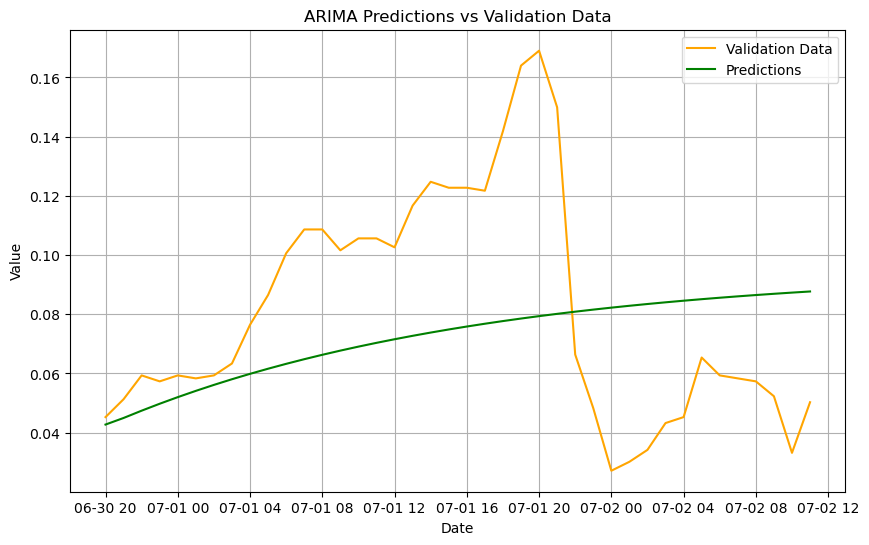

In [281]:
plt.figure(figsize=(10, 6))
plt.plot(val_df, label='Validation Data', color='orange')
plt.plot(val_df.index, forecast, label='Predictions', color='green')

plt.title('ARIMA Predictions vs Validation Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()